In [1]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


Duplicate key in file PosixPath('/Users/noora/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 265 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/Users/noora/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 273 ('font.sans-serif: SimHei, DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/Users/noora/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 414 ('axes.unicode_minus: False  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
# import pmdarima as pm
# import tensorflow as tf
# import xgboost as xgb
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from rich.progress import track
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import STLForecast

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
# tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [4]:

user_balance = pd.read_csv("user_balance_table.csv")
user_balance['report_date'] = pd.to_datetime(user_balance['report_date'], format='%Y%m%d')

user_balance.sort_values(by='report_date', inplace=True)

data = user_balance.groupby(['report_date']).sum()
train_data = data.iloc[273:396]
test_data = data.iloc[396:427]

In [5]:
def get_score(purchase_pred, redeem_pred, purchase_true, redeem_true, h=0.3):
    purchase_mape = np.abs(purchase_pred - purchase_true) / purchase_true
    redeem_mape = np.abs(redeem_pred - redeem_true) / redeem_true

    score = np.sum(np.exp(-purchase_mape / h) * 10) * 0.45 + np.sum(np.exp(-redeem_mape / h) * 10) * 0.55
    return score

In [6]:
#### STL ####
# Purchase
purchase_ts = train_data["total_purchase_amt"]
purchase_ts.index = pd.DatetimeIndex(purchase_ts.index.values,freq=purchase_ts.index.inferred_freq)
purchase_stl = STLForecast(purchase_ts, ARIMA, robust = True).fit()
purchase_pred_test_stl = purchase_stl.forecast(31)

# Redeem
redeem_ts = train_data["total_redeem_amt"]
redeem_ts.index = pd.DatetimeIndex(redeem_ts.index.values,freq=redeem_ts.index.inferred_freq)
redeem_stl = STLForecast(redeem_ts, ARIMA, robust = True).fit()
redeem_pred_test_stl = redeem_stl.forecast(31)

# If your data is really periodic and you don't have gaps in your time series, then pandas can infer the frequency.

get_score(purchase_pred_test_stl, redeem_pred_test_stl, test_data["total_purchase_amt"], test_data["total_redeem_amt"])

180.56745684926182

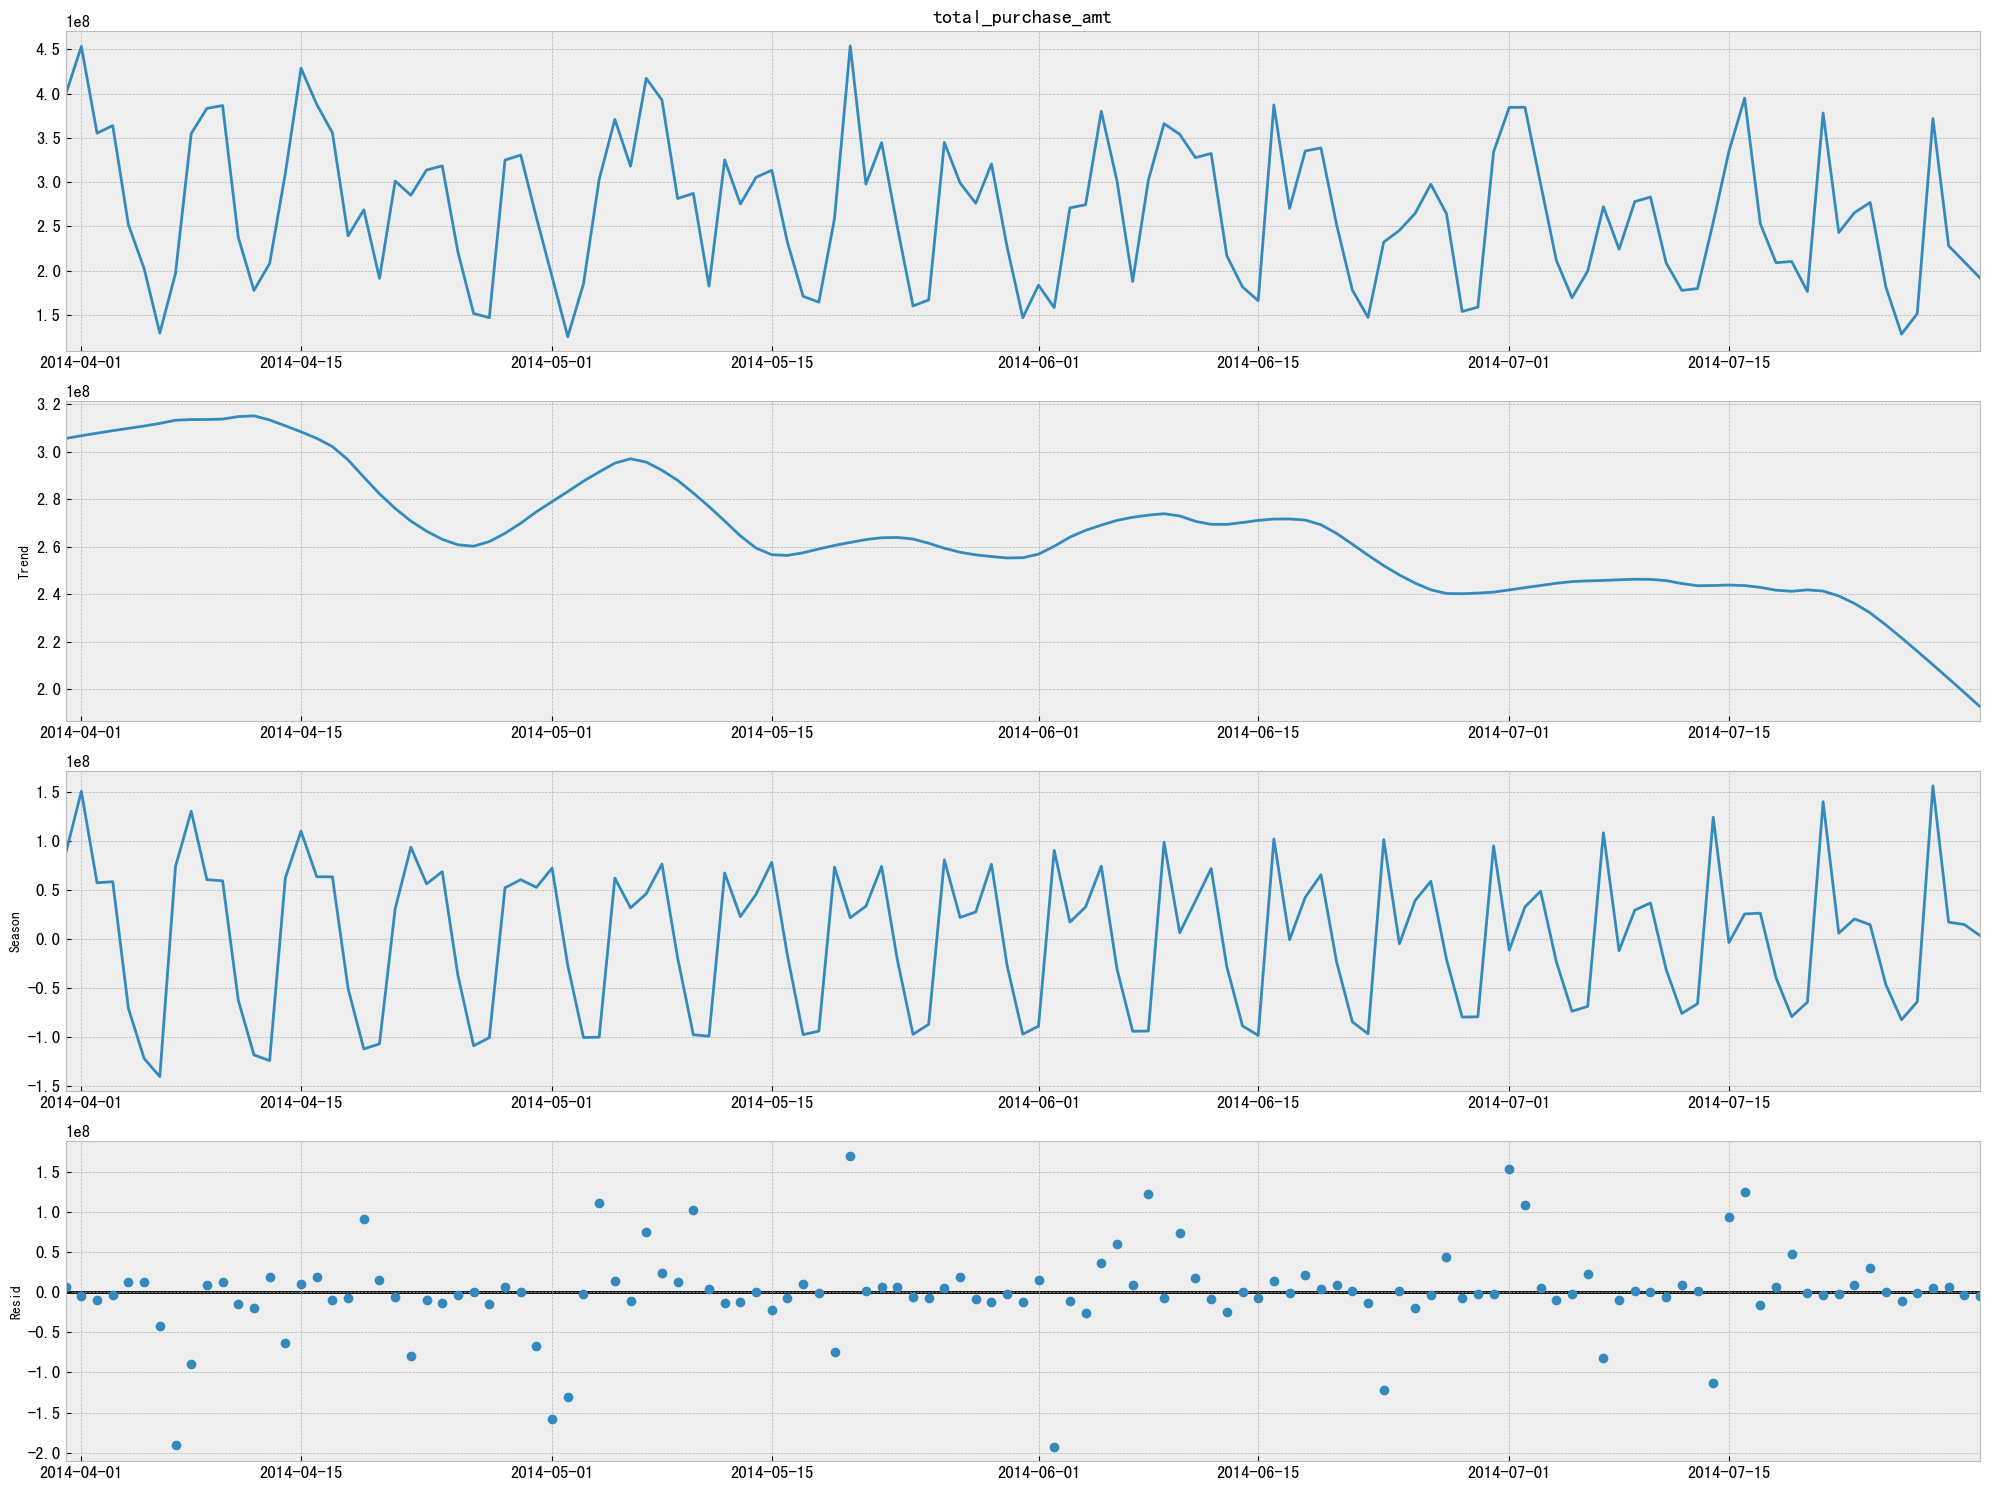

In [7]:
purchase_stl_res = STL(purchase_ts,robust = True).fit()
purchase_stl_res.plot()
plt.show()

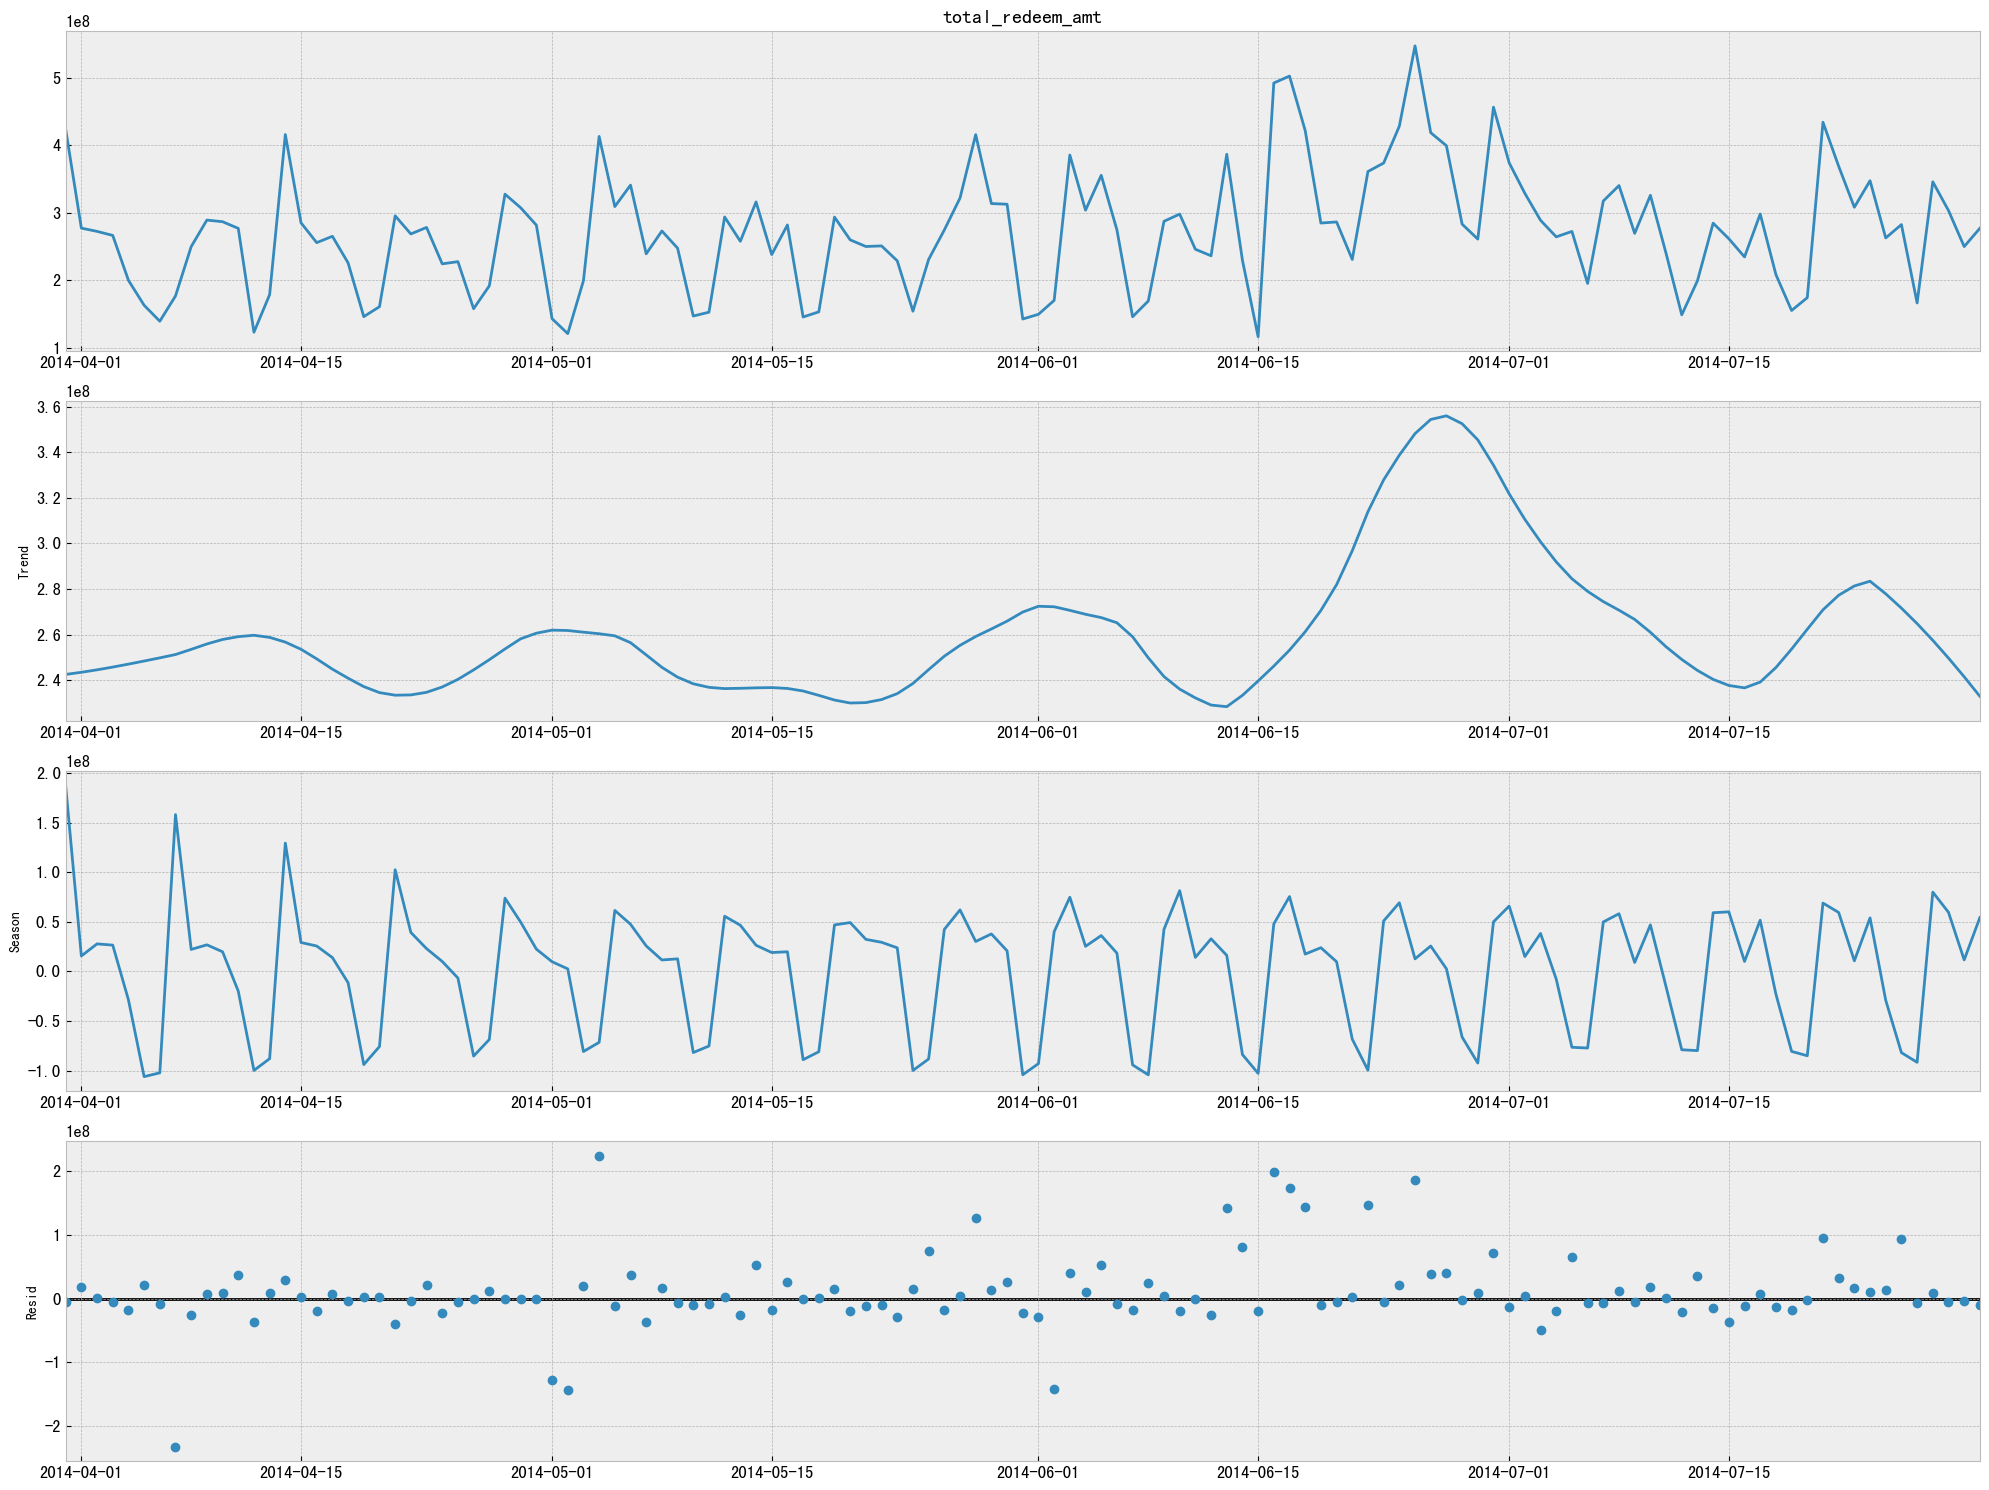

In [8]:
redeem_stl_res = STL(redeem_ts,robust = True).fit()
redeem_stl_res.plot()
plt.show()

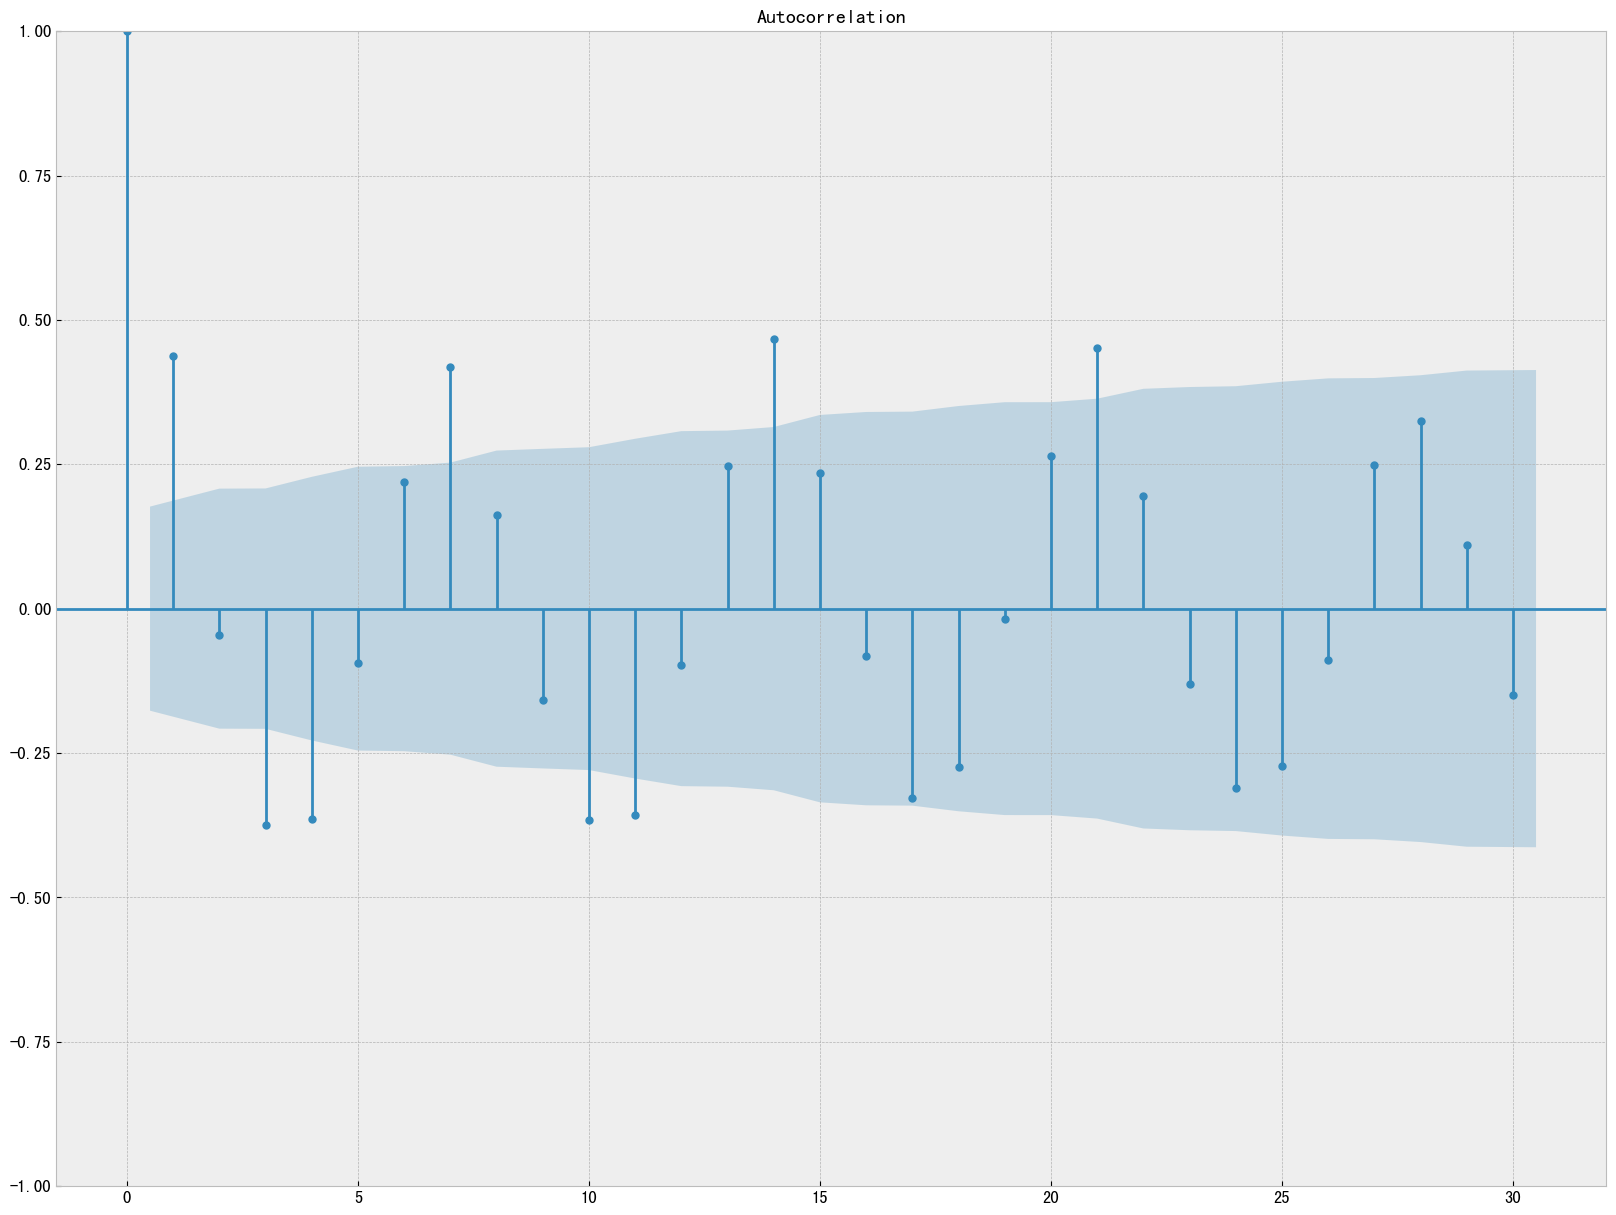

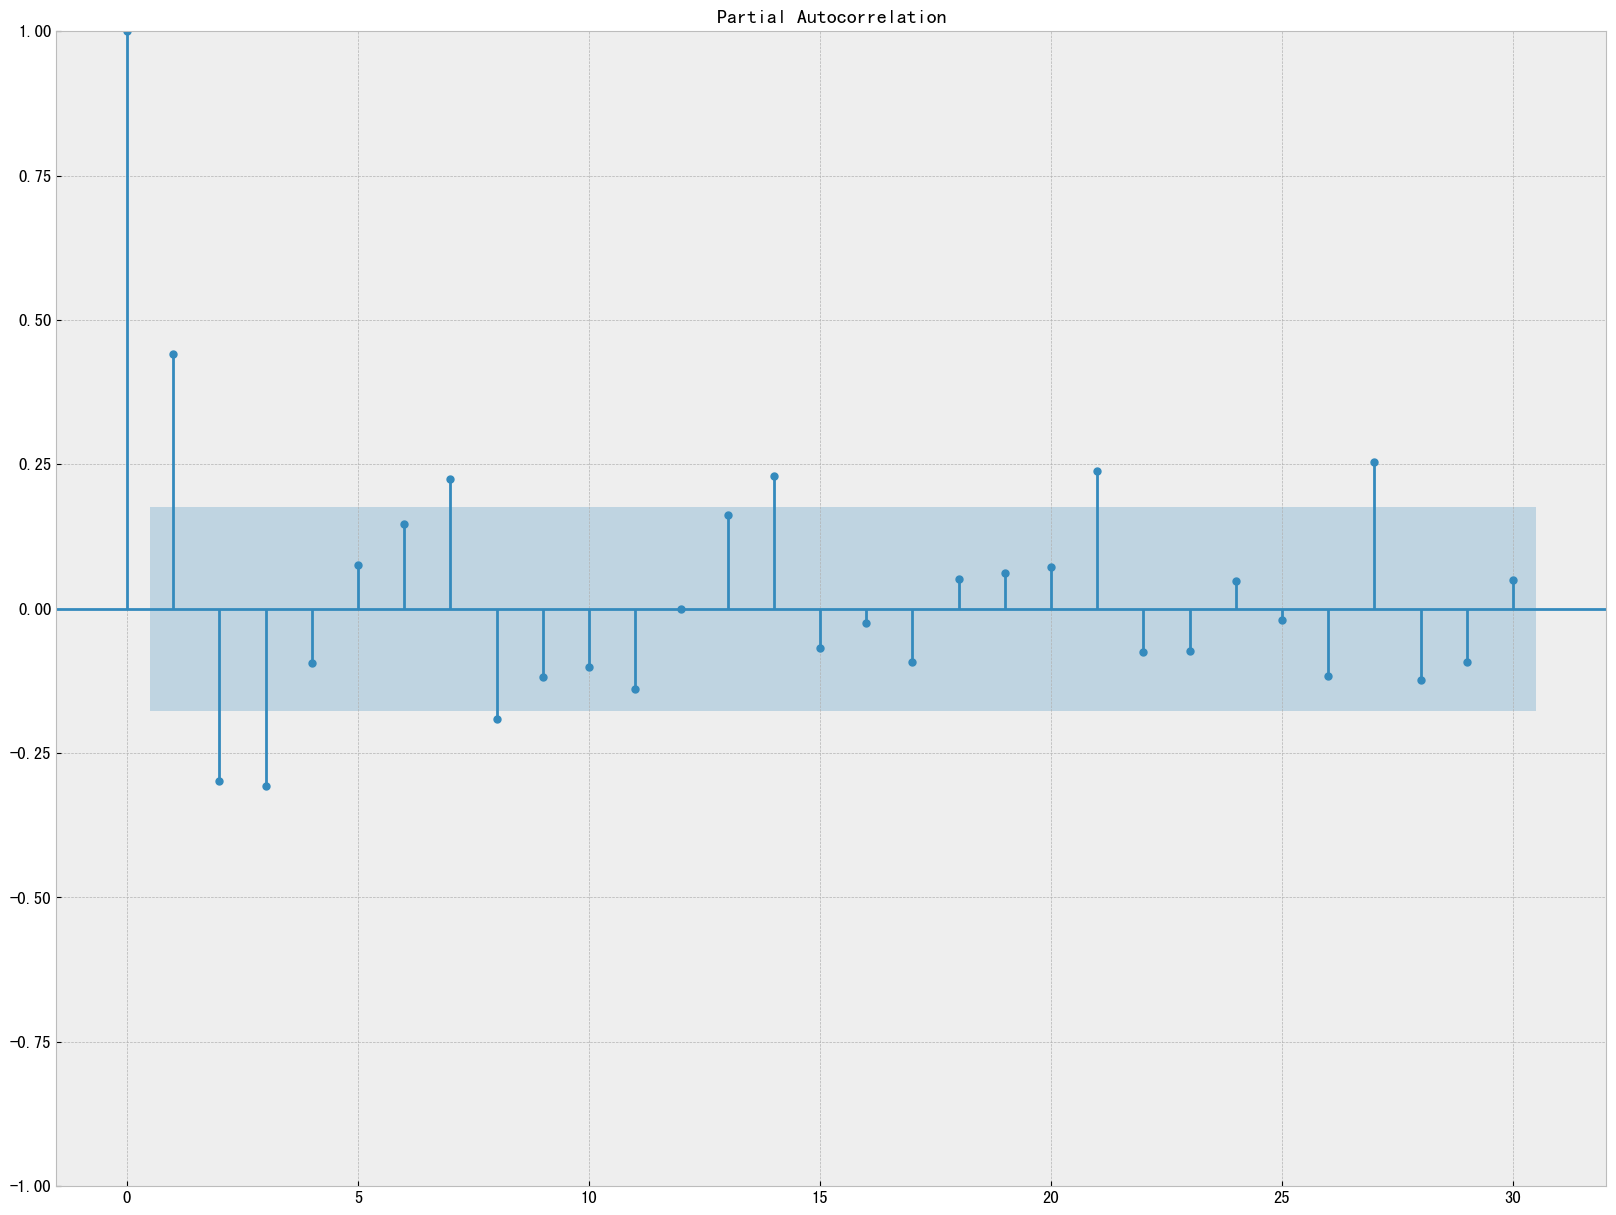

In [9]:
plot_acf(purchase_ts, lags=30)
plot_pacf(purchase_ts, lags=30)
plt.show()

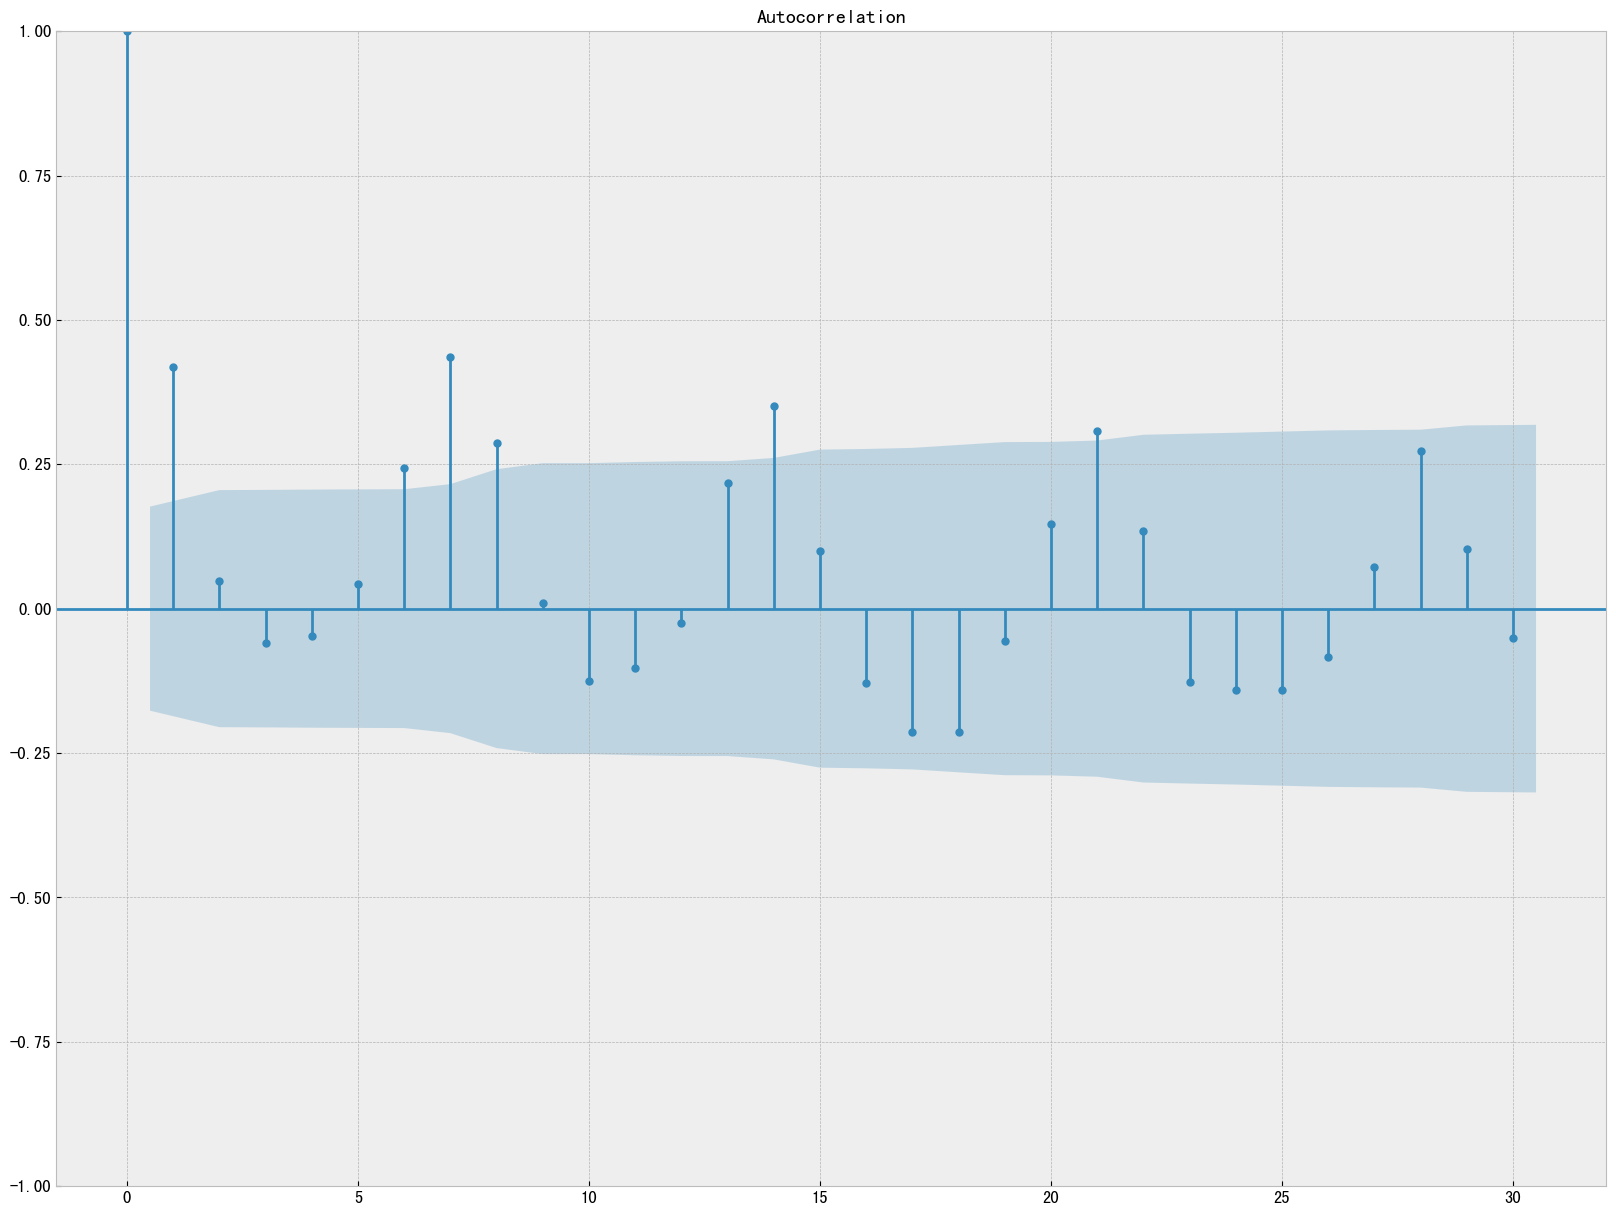

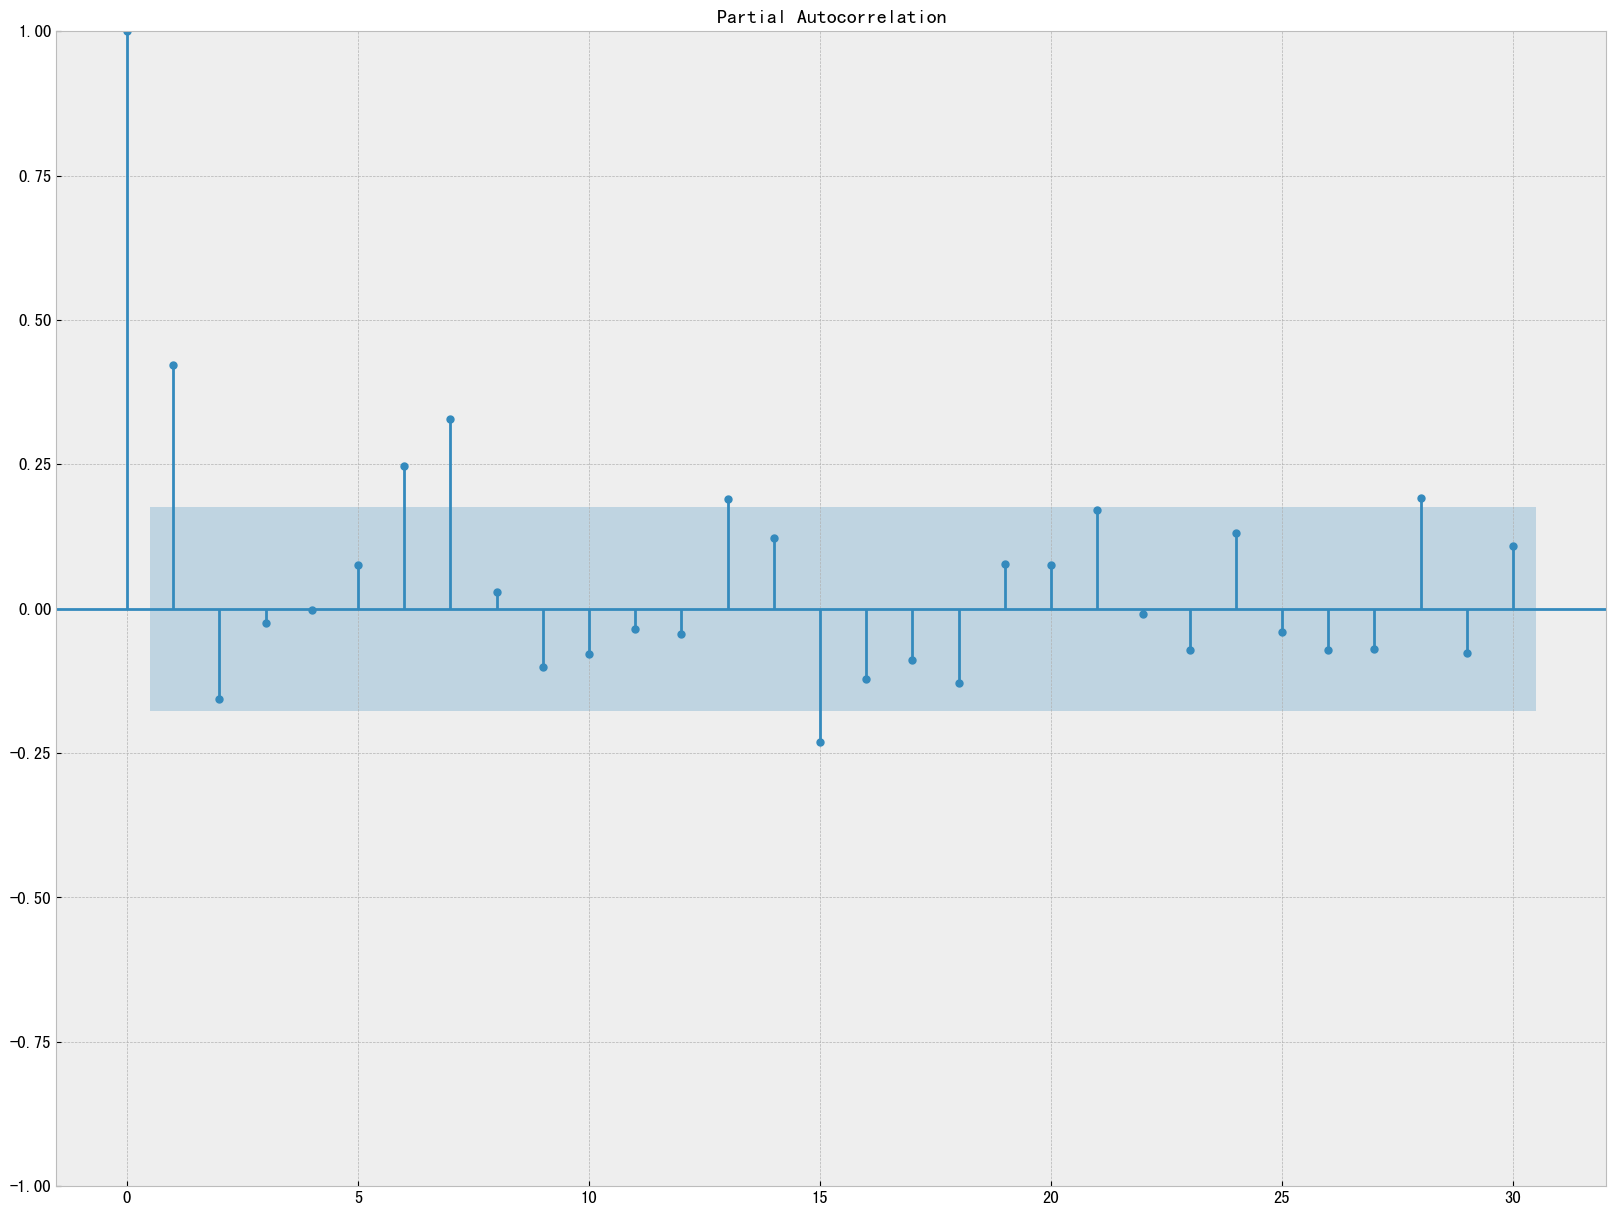

In [10]:
plot_acf(redeem_ts, lags=30)
plot_pacf(redeem_ts, lags=30)
plt.show()

In [13]:
X = purchase_ts
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.071761
p-value: 0.256020
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


可以看到 p-value: 0.694411 是大于 0.05的，所以接受原假设H0，意味着序列是不平稳的。

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(purchase_ts, lags = [7,15,30],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
7,90.293045,1.077136e-16,86.017254,8.114884e-16
15,181.457528,1.208105e-30,166.848587,1.047909e-27
30,319.169398,4.308319e-50,277.411679,7.170695e-42


由输出结果可以看到，不管是使用哪个统计量，p值都很小，所以该数据拒绝原假设，即认为该数据不是纯随机数据。